# Contents

- [Libraries](#Libraries)
- [Data](#Data)
- [Data Cleaning](#Data-Cleaning)
- [EDA](#EDA)
- [Modeling](#Modeling)
    - [Random Forest](#Random-Forest)
    - [XGBClassifier](#XGBClassifier)
    - [XGBClassifier Dart](#XGBClassifier-Dart)
- [Export Data](#Export-Data)

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
df = pd.read_csv('data/large_train_sample.csv')
print(df.shape)
df.head()

(32561, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


# Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  wage            32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


### Drop columns Unwanted Columns

In [4]:
drop_lis =['fnlwgt', 'education', 'marital-status', 'occupation']
df.drop(drop_lis, axis = 1, inplace = True)

In [5]:
df = df.drop(df.index[df.workclass == ' ?'])

### Binarize wage, sex, native country column

In [6]:
df.wage.unique()

array([' <=50K', ' >50K'], dtype=object)

In [7]:
df['wage'] = df.wage.map({' >50K': 1, ' <=50K': 0})

In [8]:
us_mask = df['native-country'] == ' United-States'
df.loc[~us_mask, 'native-country'] = 0
df.loc[us_mask, 'native-country'] = 1

df['native-country'] = df['native-country'].astype(int)

### Dummy sex, relationship and workclass columns

In [9]:
df = pd.get_dummies(df, columns = ['sex','relationship', 'workclass'], drop_first = True)

### Drop unneeded dummy columns

In [10]:
df.drop('workclass_ Never-worked', axis = 1, inplace = True)
df.drop('relationship_ Not-in-family', axis = 1, inplace = True)

# Summary Stats

In [11]:
df.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week,native-country,wage,sex_ Male,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay
count,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000
mean,38.439512,10.129699,1105.785094,88.889959,40.946461,0.895395,0.248983,0.676745,0.029878,0.147437,0.106461,0.046737,0.068120,0.738682,0.036322,0.082701,0.042246,0.000456
std,13.119665,2.562702,7497.027762,405.613208,11.987385,0.306049,0.432431,0.467727,0.170253,0.354547,0.308431,0.211079,0.251957,0.439360,0.187094,0.275435,0.201153,0.021342
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# EDA

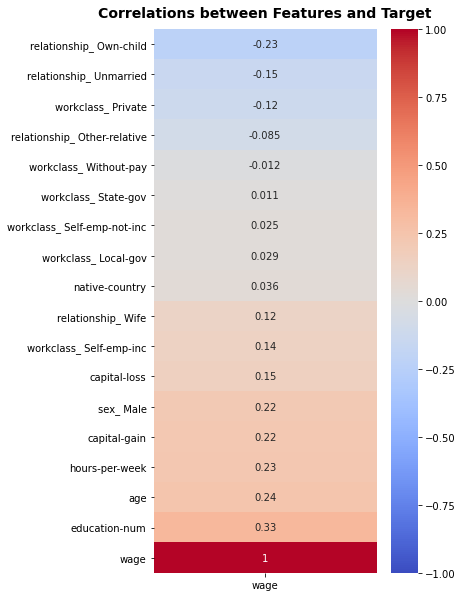

In [12]:
plt.figure(figsize = (5,10))
sns_plot = sns.heatmap(df.corr()[['wage']].sort_values('wage'),
           annot=True,
           cmap='coolwarm',
           vmin=-1,
           vmax=1)
plt.title('Correlations between Features and Target', fontsize = 14, fontweight = 'bold', pad = 12);

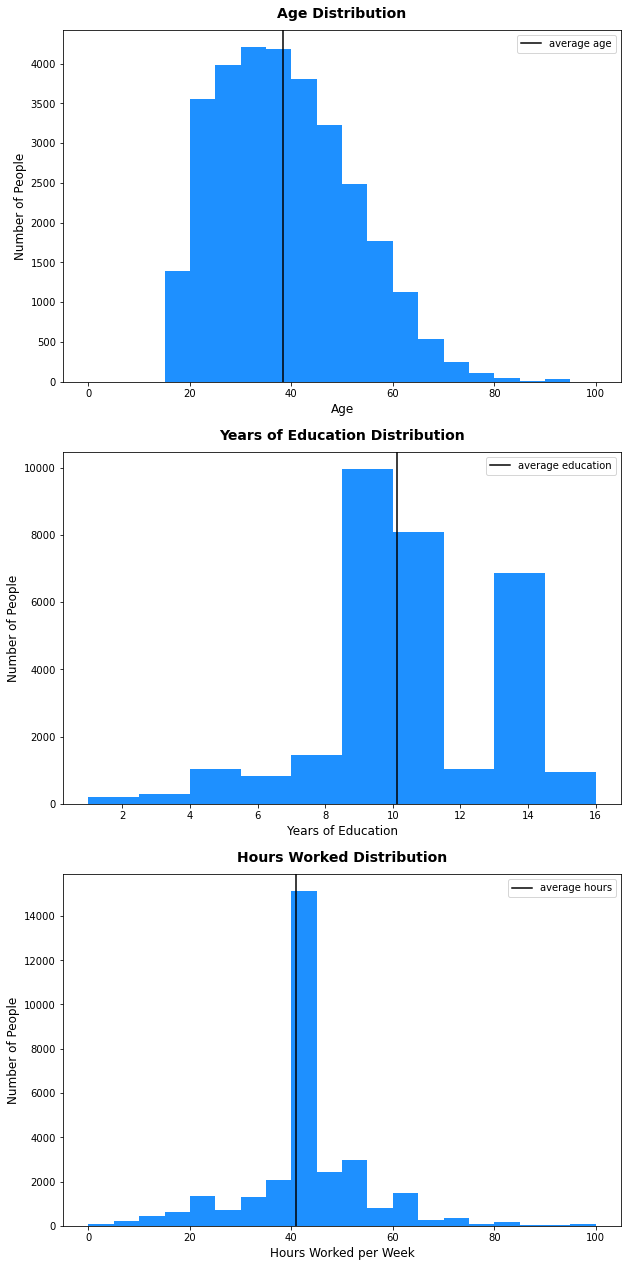

In [13]:
fig, ax = plt.subplots(3, 1, figsize = (10, 22))

ax[0].hist(df['age'], bins = 20, range = (0, 100), color = 'dodgerblue')
ax[0].axvline(x = df['age'].mean(), color = 'k', label = 'average age')
ax[0].set_xlabel('Age', fontsize = 12)
ax[0].set_ylabel('Number of People', fontsize = 12)
ax[0].set_title('Age Distribution', fontsize = 14, fontweight = 'bold', pad = 12)
ax[0].legend()

ax[1].hist(df['education-num'], color = 'dodgerblue')
ax[1].axvline(x = df['education-num'].mean(), color = 'k', label = 'average education')
ax[1].set_xlabel('Years of Education', fontsize = 12)
ax[1].set_ylabel('Number of People', fontsize = 12)
ax[1].set_title('Years of Education Distribution', fontsize = 14, fontweight = 'bold', pad = 12)
ax[1].legend()

ax[2].hist(df['hours-per-week'], bins = 20, range = (0, 100), color = 'dodgerblue')
ax[2].axvline(x = df['hours-per-week'].mean(), color = 'k', label = 'average hours')
ax[2].set_xlabel('Hours Worked per Week', fontsize = 12)
ax[2].set_ylabel('Number of People', fontsize = 12)
ax[2].set_title('Hours Worked Distribution', fontsize = 14, fontweight = 'bold', pad = 12)
ax[2].legend();

# Modeling

In [14]:
X = df.drop(columns = ['wage'])
y = df['wage']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 6)

In [15]:
df['wage'].value_counts(normalize = True)

0    0.751017
1    0.248983
Name: wage, dtype: float64

## Random Forest

In [16]:
params = {
    'max_depth': [1, 2, 3, 4, 6, 8],
    'min_samples_leaf': [2, 3],
    'n_estimators': [175],
    'n_jobs': [-1]
}
    
gs = GridSearchCV(RandomForestClassifier(random_state = 6),
                  param_grid = params)
gs.fit(X_train, y_train)
print('Cross val score:', (gs.best_score_))
gs.best_params_

Cross val score: 0.8419037292676166


{'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 175, 'n_jobs': -1}

### Cross Val Scores

In [17]:
params = gs.best_params_
scores = cross_val_score(gs, 
                         X, y,
                         cv = 5,
                         n_jobs = -1)

print(f'Score on training set: {gs.score(X_train, y_train)}')
print(f'Score on testing set: {gs.score(X_test, y_test)}')
print('Accuracy: {:.4f} ± {:.4f}'.format(scores.mean(), 
                                 2 * scores.std()))

Score on training set: 0.8462005815215032
Score on testing set: 0.8372819578234835
Accuracy: 0.8424 ± 0.0046


**Evaluation:** The model displays good accuracy scores for both test and train data, numbers closer to 1.
The accuracy score is slightly lower for the test data compared to the train data indicating an overfit of the model. This is typically expected with RF models. When compared to the UCI repository, the original site of the data, our model, with feature constraints performed as expected.

### Confusion Matrix - Random Forest

Accuracy: 0.8372819578234835
Specificity: 0.962169632060805
Sensitivity: 0.45536185948230323
Precision: 0.7974098057354302
F1: 0.5796906523201076


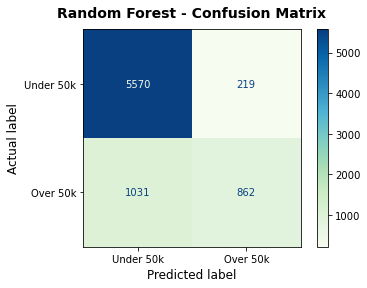

In [18]:
rf_pred = gs.predict(X_test)
metrics.confusion_matrix(y_test, rf_pred)
metrics.plot_confusion_matrix(gs, X_test, y_test, cmap = 'GnBu', 
                              values_format = 'd', display_labels=['Under 50k', 'Over 50k']);

plt.xlabel('Predicted label', fontsize = 12); plt.ylabel('Actual label', fontsize = 12)
plt.title('Random Forest - Confusion Matrix', fontsize = 14, fontweight = 'bold', pad = 12)

metrics.confusion_matrix(y_test, rf_pred).ravel()
tn, fp, fn, tp = metrics.confusion_matrix(y_test, rf_pred).flatten()
print('Accuracy:', metrics.accuracy_score(y_test, rf_pred))
print('Specificity:', (tn / (tn + fp)))
print('Sensitivity:', metrics.recall_score(y_test, rf_pred))
print('Precision:', metrics.precision_score(y_test, rf_pred))
print('F1:', metrics.f1_score(y_test, rf_pred));

### ROC Curve - Random Forest

ROC AUC Score: 0.888


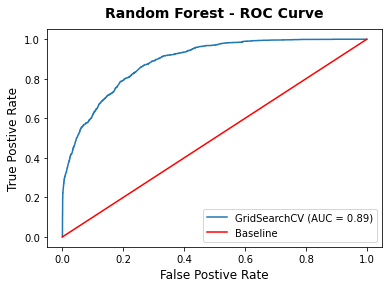

In [19]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs.predict_proba(X_test)[:,1]})

metrics.plot_roc_curve(gs, X_test, y_test)

plt.plot([0, 1], [0, 1], color='r', label='Baseline')
plt.xlabel('False Postive Rate', fontsize = 12); plt.ylabel('True Postive Rate', fontsize = 12)
plt.title('Random Forest - ROC Curve', fontsize = 14, fontweight = 'bold', pad = 12)
plt.legend();

print('ROC AUC Score:', round(metrics.roc_auc_score(y_test, pred_df['pred_probs']), 3))

## XGBClassifier

In [20]:
params_2 = {
    'max_depth': [1, 2, 3, 4, 6, 8],
    'verbosity': [0],
    'eta': [.1, .2, .4],
    'n_estimators': [175],
    'n_jobs': [-1]
}
    
gs_2 = GridSearchCV(XGBClassifier(random_state = 6), 
                    param_grid = params_2)
gs_2.fit(X_train, y_train)
print('Cross val score:', (gs_2.best_score_))
gs_2.best_params_

Cross val score: 0.8557908289337288


{'eta': 0.4, 'max_depth': 2, 'n_estimators': 175, 'n_jobs': -1, 'verbosity': 0}

### Cross Val Scores

In [21]:
params_2 = gs_2.best_params_
scores_2 = cross_val_score(gs_2, 
                           X_train, y_train, 
                           cv = 5, 
                           n_jobs = -1)

print(f'Score on training set: {gs_2.score(X_train, y_train)}')
print(f'Score on testing set: {gs_2.score(X_test, y_test)}')
print('Accuracy: {:.4f} ± {:.4f}'.format(scores_2.mean(), 
                                 2 * scores_2.std()))

Score on training set: 0.8597404851798811
Score on testing set: 0.852902889872429
Accuracy: 0.8540 ± 0.0086


### Confusion Matrix - XGBClassifier

Accuracy: 0.852902889872429
Specificity: 0.9447227500431854
Sensitivity: 0.572107765451664
Precision: 0.7719173200285103
F1: 0.6571601941747572


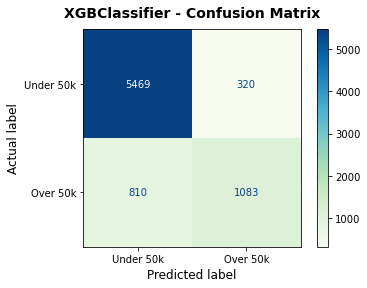

In [22]:
xg_pred = gs_2.predict(X_test)
metrics.confusion_matrix(y_test, xg_pred)
metrics.plot_confusion_matrix(gs_2, X_test, y_test, cmap = 'GnBu', 
                              values_format = 'd', display_labels=['Under 50k', 'Over 50k'])

plt.xlabel('Predicted label', fontsize = 12); plt.ylabel('Actual label', fontsize = 12)
plt.title('XGBClassifier - Confusion Matrix', fontsize = 14, fontweight = 'bold', pad = 12)

metrics.confusion_matrix(y_test, xg_pred).ravel()
tn, fp, fn, tp = metrics.confusion_matrix(y_test, xg_pred).flatten()
print('Accuracy:', gs_2.score(X_test, y_test))
print('Specificity:', (tn / (tn + fp)))
print('Sensitivity:', metrics.recall_score(y_test, xg_pred))
print('Precision:', metrics.precision_score(y_test, xg_pred))
print('F1:', metrics.f1_score(y_test, xg_pred))

### ROC Curve - XGBClassifier

ROC AUC Score: 0.909


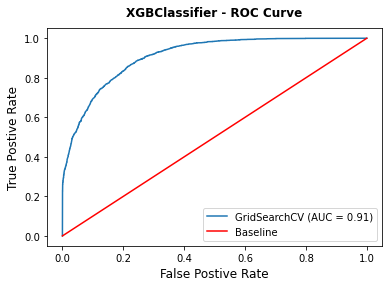

In [23]:
pred2_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs_2.predict_proba(X_test)[:,1]})

metrics.plot_roc_curve(gs_2, X_test, y_test)

plt.plot([0, 1], [0, 1], color='r', label='Baseline')
plt.xlabel('False Postive Rate', fontsize = 12); plt.ylabel('True Postive Rate', fontsize = 12)
plt.title('XGBClassifier - ROC Curve', fontweight = 'bold', pad = 12)
plt.legend();

print('ROC AUC Score:', round(metrics.roc_auc_score(y_test, pred2_df['pred_probs']), 3))

## XGBClassifier Dart

In [24]:
params_3 = {
    'booster' : ['dart'],
    'verbosity' : [0],
    'use_label_encoder' : [False],
    'sample_type' : ['uniform', 'weighted'],
    'normalize_type' : ['tree', 'forest'],
    'rate_drop' : [0, .1,],
    'one_drop' : [0, 1],
    'n_jobs' : [-1]
}

gs_3 = GridSearchCV(XGBClassifier(random_state = 6), 
                    param_grid = params_3)
gs_3.fit(X_train, y_train)
print(gs_3.best_score_)
gs_3.best_params_

0.854272061305176


{'booster': 'dart',
 'n_jobs': -1,
 'normalize_type': 'tree',
 'one_drop': 1,
 'rate_drop': 0,
 'sample_type': 'uniform',
 'use_label_encoder': False,
 'verbosity': 0}

### Cross Val Scores

In [25]:
params_3 = gs_3.best_params_
scores_3 = cross_val_score(gs_3, 
                           X_train, y_train, 
                           cv = 5, 
                           n_jobs = -1)

print(f'Score on training set: {gs_3.score(X_train, y_train)}')
print(f'Score on testing set: {gs_3.score(X_test, y_test)}')
print('Accuracy: {:.4f} ± {:.4f}'.format(scores_2.mean(), 
                                 2 * scores.std()))

Score on training set: 0.872369049168945
Score on testing set: 0.8525123665712054
Accuracy: 0.8540 ± 0.0046


### Confusion Matrix - XGBClassifier Dart

Accuracy: 0.8525123665712054
Specificity: 0.9455864570737605
Sensitivity: 0.5678816693079768
Precision: 0.7733812949640287
F1: 0.6548888212001218


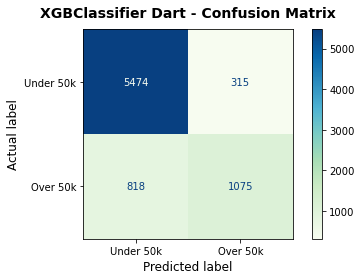

In [26]:
dart_pred = gs_3.predict(X_test)
metrics.confusion_matrix(y_test, dart_pred)
metrics.plot_confusion_matrix(gs_3, X_test, y_test, cmap = 'GnBu', 
                              values_format = 'd', display_labels=['Under 50k', 'Over 50k'])

plt.xlabel('Predicted label', fontsize = 12); plt.ylabel('Actual label', fontsize = 12)
plt.title('XGBClassifier Dart - Confusion Matrix', fontsize = 14, fontweight = 'bold', pad = 12)
plt.tight_layout();

metrics.confusion_matrix(y_test, dart_pred).ravel()
tn, fp, fn, tp = metrics.confusion_matrix(y_test, dart_pred).flatten()
print('Accuracy:', gs_3.score(X_test, y_test))
print('Specificity:', (tn / (tn + fp)))
print('Sensitivity:', metrics.recall_score(y_test, dart_pred))
print('Precision:', metrics.precision_score(y_test, dart_pred))
print('F1:', metrics.f1_score(y_test, dart_pred))

### ROC Curve - XGBClassifier Dart

ROC AUC Score: 0.91


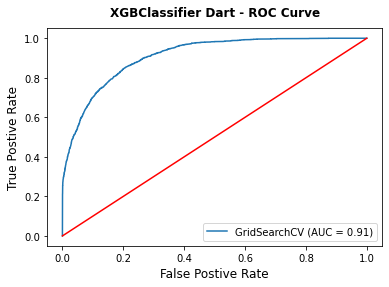

In [27]:
pred3_df = pd.DataFrame({'true_values': y_test,
                         'pred_probs': gs_3.predict_proba(X_test)[:,1]})

metrics.plot_roc_curve(gs_3, X_test, y_test)

plt.plot([0, 1], [0, 1], color='r', label='Baseline')
plt.xlabel('False Postive Rate', fontsize = 12); plt.ylabel('True Postive Rate', fontsize = 12)
plt.title('XGBClassifier Dart - ROC Curve', fontweight = 'bold', pad = 12)

print('ROC AUC Score:', round(metrics.roc_auc_score(y_test, pred3_df['pred_probs']), 3))

# Export Data

In [28]:
x_sub = pd.read_csv('./data/test_data.csv')

drop_lis =['fnlwgt', 'education', 'marital-status', 'occupation']
x_sub.drop(drop_lis, axis = 1, inplace = True)

us_mask = x_sub['native-country'] == ' United-States'
x_sub.loc[~us_mask, 'native-country'] = 0
x_sub.loc[us_mask, 'native-country'] = 1
x_sub['native-country'] = x_sub['native-country'].astype(int)

x_sub = x_sub.drop(x_sub.index[x_sub.workclass == ' ?'])

x_sub = pd.get_dummies(x_sub, columns=['sex', 'relationship','workclass'], drop_first = True)

x_sub.drop('workclass_ Never-worked', axis = 1, inplace = True)
x_sub.drop('relationship_ Not-in-family', axis = 1, inplace = True)

In [29]:
wage_sub = gs_2.predict(x_sub)
sf = pd.DataFrame(wage_sub, columns = ['wage'])
sf.to_csv('./data/sub.csv')